Sample script for MNLab2BICN.

メディアネットワーク実験IIB 項目Iで利用するサンプル．

PSK および QAM は適切に実装されていません．
`# Start of 要修正` から `# End of 要修正` の箇所を修正する必要があります．
なお，行中の一部を修正すれば良いというわけではなく，
必要に応じて行の追加が必要になります．

必要なファイルを`github`から取り出す．

In [1]:
!test -d mnlab2bicn && (cd mnlab2bicn ; git pull) || git clone https://github.com/htsutsui/mnlab2bicn/
!cp mnlab2bicn/mnlab2bicn.py .
!cp mnlab2bicn/gray.py .

Cloning into 'mnlab2bicn'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 128 (delta 70), reused 87 (delta 42), pack-reused 0 (from 0)
Receiving objects: 100% (128/128), 30.72 KiB | 2.36 MiB/s, done.
Resolving deltas: 100% (70/70), done.


`mnlab2bicn`が依存する`gmpy2` (BER計算を高速化する)をインストールする．
なお，`gmpy2`が無くてもBER計算は可能(若干遅くなる)なので，エラーが生じる場合は無視すること．

In [2]:
!sudo apt-get update
!sudo apt-get install -y libgmp-dev libmpfr-dev libmpc-dev
!pip install gmpy2

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,517 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,614 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd

NumPy と Matplotlib を使うので`import`する．

In [4]:
import matplotlib.pyplot as plt
import numpy as np

実験で使用するあらかじめ用意されている関数を`import`する．

In [5]:
from mnlab2bicn import awgn, calc_ser, calc_ber, \
    int2gray, gray2int, scatter_plot

このscript中で利用するdebug用の変数．

In [6]:
verbose = True # True だと for loop の処理の状況(進み具合)が確認できる
verbose_awgn = False

PSKのシミュレーションを行う関数を定義する．

In [7]:
def psk_test(m_level, i_snr, i_size, plot=False, gray=False):
    """PSK test

    Parameters
    ----------
    m_level: modulation level (integer)
    i_snr: SNR in dB
    i_size: number of samples
    plot: optional. if True, scatter plot will be generated.
    gray: optional. if True, gray code is used.

    Returns
    -------
    (SER, BER)
    """
    src = np.random.randint(m_level, size=i_size)

    x = int2gray(src) if gray else src

    # Start of 要修正
    # y = x / (m_level - 1)
    y = np.exp(1j * 2 * np.pi /m_level*x)
    # End of 要修正

    y_noisy = awgn(y, i_snr, verbose_awgn)

    if plot:
        scatter_plot(y_noisy, f"PSK_{m_level}_{i_snr}_{i_size}")

    # Start of 要修正
    #z = np.round(y_noisy.real * (m_level - 1))
    #z = np.where(z < 0, 0, z)
    #z = np.where(z > m_level - 1, m_level - 1, z)
    #z=np.angle(y_noisy)
    #z=z/(2*np.pi/y_noisy)
    #z=z.round()

    # 受信信号の位相を取得 (-π ~ π)
    z = np.angle(y_noisy)
    # 負の位相を正の値に変換 (0 ~ 2π)
    z = np.where(z < 0, z + 2*np.pi, z)
    # 位相から最も近いシンボルを決定
    z = np.round(z * m_level / (2*np.pi))
    z = np.where(z == m_level, 0, z)  # 2πの場合は0のシンボルに対応

    # End of 要修正

    z = np.array(z, dtype='int')

    dst = gray2int(z) if gray else z

    return (calc_ser(src, dst), calc_ber(src, dst, m_level))

QAMのシミュレーションを行う関数を定義する．

In [65]:
def qam_test(m_level, i_snr, i_size, plot=False, gray=False):
    """QAM test

    Parameters
    ----------
    m_level: modulation level (integer)
    i_snr: SNR in dB
    i_size: number of samples
    plot: optional. if True, scatter plot will be generated.
    gray: optional. if True, gray code is used.

    Returns
    -------
    (SER, BER)
    """
    src = np.random.randint(m_level, size=i_size)
    k = int(np.log2(m_level))
    smax = 2 ** (k // 2) - 1

    yr = src >> (k // 2)
    yi = src & smax

    yr = int2gray(yr) if gray else yr
    yi = int2gray(yi) if gray else yi

    # Start of 要修正
    #y = np.exp(1j * (2 * np.pi) / (smax + 1) * yr)
    #y *= ((yi + 1) / (smax + 1))
    # 振幅を[-smax, smax]の範囲に正規化
    yr = 2 * yr / smax - 1
    yi = 2 * yi / smax - 1
    y = yr + 1j * yi
    y *= np.sqrt(1 / (2 * ((smax + 1)**2 / smax**2)))


    # End of 要修正

    y_noisy = awgn(y, i_snr, verbose_awgn)

    if plot:
        scatter_plot(y_noisy, f"QAM_{m_level}_{i_snr}_{i_size}")

    # Start of 要修正
    '''
    zr = np.round(np.angle(y_noisy)/((2 * np.pi) / (smax + 1)))
    zr += (zr < 0)*(smax + 1)
    zr = np.array(zr, dtype='int')

    zi = np.round(np.abs(y_noisy) * (smax + 1))
    zi = np.array(zi, dtype='int')
    zi -= 1

    '''
    zr = (y_noisy.real + 1) / 2 * smax
    zi = (y_noisy.imag + 1) / 2 * smax
    zr = zr.round()
    zi = zi.round()
    zr = np.array(zr, dtype='int')
    zi = np.array(zi, dtype='int')
    # End of 要修正

    zr = np.where(zr < 0, 0, zr)
    zr = np.where(zr > smax, smax, zr)
    zi = np.where(zi < 0, 0, zi)
    zi = np.where(zi > smax, smax, zi)

    zr = gray2int(zr) if gray else zr
    zi = gray2int(zi) if gray else zi

    dst = zr << (k // 2)
    dst += zi

    return (calc_ser(src, dst), calc_ber(src, dst, m_level))

グラフのフォントサイズを調整する．

In [9]:
plt.rcParams.update({'font.size': 16})

PSKのシミュレーションを行う．図は`PSK_4_30_100.png`および`PSK_4_30_100.pdf`に保存される．以下同様．

返り値は(SER, BER)．多値数，SNR，およびサンプル数を様々に変更してシミュレーションする(課題1，2)．

In [47]:
print(psk_test(4, 0, 4000, plot=False))
print(psk_test(4, 4, 4000, plot=False))
print(psk_test(4, 8, 4000, plot=False))
print(psk_test(4, 12, 4000, plot=False))
print(psk_test(8, 0, 4000, plot=False))
print(psk_test(8, 4, 4000, plot=False))
print(psk_test(8, 8, 4000, plot=False))
print(psk_test(8, 12, 4000, plot=False))

(0.28675, 0.208375)
(0.11925, 0.09)
(0.01375, 0.011125)
(0.00025, 0.00025)
(0.574, 0.33391666666666664)
(0.3925, 0.2275)
(0.1665, 0.09825)
(0.03475, 0.020916666666666667)


In [59]:
for i in range(9):
  print(i)
  print(psk_test(4, 12, 10**i, plot=False))

0
(0.0, 0.0)
1
(0.0, 0.0)
2
(0.0, 0.0)
3
(0.0, 0.0)
4
(0.0001, 0.0001)
5
(0.00011, 7e-05)
6
(5.9e-05, 4.3e-05)
7
(6.54e-05, 4.945e-05)
8
(6.879e-05, 5.207e-05)


In [60]:
psk_test(4, 12, 20000000, plot=False)

(6.63e-05, 4.935e-05)

QAMのシミュレーションを行う．

返り値は(SER, BER)．多値数，SNR，およびサンプル数を様々に変更してシミュレーションする(課題1，2)．

In [44]:
print(qam_test(16, 0, 4000, plot=False))
print(qam_test(16, 4, 4000, plot=False))
print(qam_test(16, 8, 4000, plot=False))
print(qam_test(16, 12, 4000, plot=False))
print(qam_test(64, 0, 4000, plot=False))
print(qam_test(64, 4, 4000, plot=False))
print(qam_test(64, 8, 4000, plot=False))
print(qam_test(64, 12, 4000, plot=False))

(0.7745, 0.340375)
(0.7335, 0.3045625)
(0.725, 0.271875)
(0.70975, 0.243375)
(0.94025, 0.386875)
(0.90875, 0.3546666666666667)
(0.9, 0.3340416666666667)
(0.883, 0.319125)


(0.89475, 0.34070833333333334)

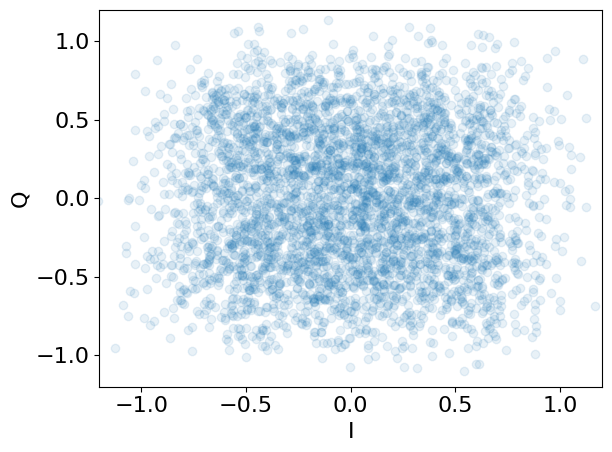

In [38]:
qam_test(64, 6, 4000, plot=True)

グラフのフォントサイズを調整する．

In [61]:
plt.rcParams.update({'font.size': 12})

PSK/QAM Comparison

課題3．サンプル数(`size`)は適宜調整すること．

[0, 64, 0.9457, 0.42078333333333334]
[2, 64, 0.9349, 0.4007]
[4, 64, 0.9142, 0.3822833333333333]
[6, 64, 0.8858, 0.3546]
[8, 64, 0.8645, 0.33253333333333335]
[10, 64, 0.8323, 0.30828333333333335]
[12, 64, 0.7821, 0.2751166666666667]
[14, 64, 0.7241, 0.24876666666666666]
[16, 64, 0.6632, 0.22036666666666666]
[18, 64, 0.5763, 0.19125]
[20, 64, 0.4867, 0.15833333333333333]
[22, 64, 0.3877, 0.12988333333333332]
[24, 64, 0.273, 0.08826666666666666]
[26, 64, 0.1649, 0.054816666666666666]
[28, 64, 0.0765, 0.0249]
[30, 64, 0.0279, 0.009033333333333334]
[32, 64, 0.006, 0.002183333333333333]
[34, 64, 0.0007, 0.0003]
[36, 64, 0.0, 0.0]
[0, 64, 0.9341, 0.38416666666666666]
[2, 64, 0.9232, 0.371]
[4, 64, 0.914, 0.3575333333333333]
[6, 64, 0.8999, 0.34125]
[8, 64, 0.8997, 0.33641666666666664]
[10, 64, 0.8982, 0.3283333333333333]
[12, 64, 0.8933, 0.32875]
[14, 64, 0.8871, 0.32306666666666667]
[16, 64, 0.8924, 0.3194166666666667]
[18, 64, 0.8947, 0.31643333333333334]
[20, 64, 0.8957, 0.313016666666666

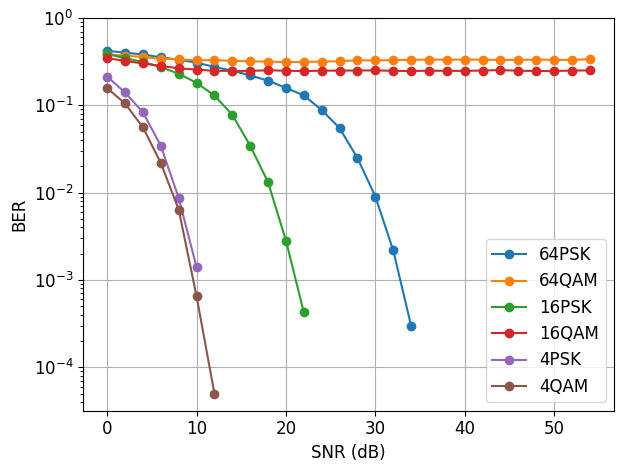

In [66]:
size = 10000
for m in [64, 16, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK")
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = qam_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}QAM")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("PSK_QAM.png")
plt.savefig("PSK_QAM.pdf")

PSK Gray Code Comparison

課題4．サンプル数(`size`)は適宜調整すること．

[0, 64, 0.9404, 0.42218333333333335]
[2, 64, 0.9253, 0.39998333333333336]
[4, 64, 0.9127, 0.38005]
[6, 64, 0.8928, 0.35545]
[8, 64, 0.8582, 0.32713333333333333]
[10, 64, 0.8363, 0.30433333333333334]
[12, 64, 0.7765, 0.27471666666666666]
[14, 64, 0.7251, 0.24775]
[16, 64, 0.6557, 0.21708333333333332]
[18, 64, 0.5862, 0.19421666666666668]
[20, 64, 0.4879, 0.16143333333333335]
[22, 64, 0.3752, 0.12418333333333334]
[24, 64, 0.2703, 0.08828333333333334]
[26, 64, 0.1679, 0.054683333333333334]
[28, 64, 0.0823, 0.026866666666666667]
[30, 64, 0.0257, 0.008933333333333333]
[32, 64, 0.0057, 0.00185]
[34, 64, 0.0005, 8.333333333333333e-05]
[36, 64, 0.0, 0.0]
[0, 64, 0.941, 0.3811]
[2, 64, 0.9296, 0.3575]
[4, 64, 0.9121, 0.32905]
[6, 64, 0.8861, 0.30038333333333334]
[8, 64, 0.8595, 0.27193333333333336]
[10, 64, 0.8309, 0.2486]
[12, 64, 0.78, 0.2193]
[14, 64, 0.7293, 0.19501666666666667]
[16, 64, 0.6684, 0.16785]
[18, 64, 0.5813, 0.13965]
[20, 64, 0.4906, 0.11153333333333333]
[22, 64, 0.3806, 0.0851

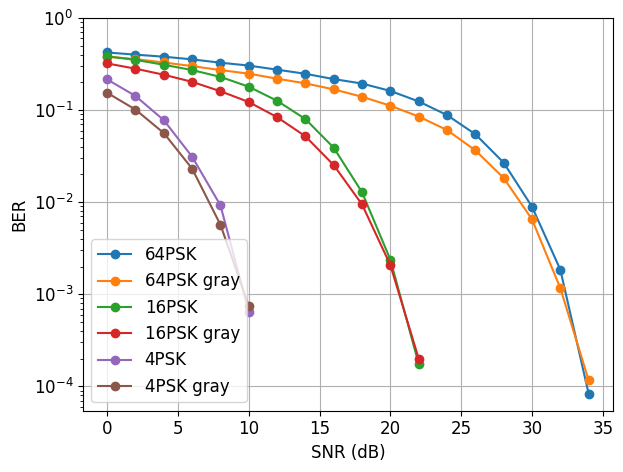

In [63]:
size = 10000
for m in [64, 16, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK")
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size, gray=True)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK gray")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("PSK_gray.png")
plt.savefig("PSK_gray.pdf")

QAM Gray Code Comparison

課題4．サンプル数(`size`)は適宜調整すること．

[0, 64, 0.9326, 0.38813333333333333]
[2, 64, 0.9187, 0.3702166666666667]
[4, 64, 0.9118, 0.3559833333333333]
[6, 64, 0.9017, 0.34171666666666667]
[8, 64, 0.894, 0.3358]
[10, 64, 0.8978, 0.3305]
[12, 64, 0.8956, 0.32481666666666664]
[14, 64, 0.8914, 0.32188333333333335]
[16, 64, 0.8931, 0.32038333333333335]
[18, 64, 0.8894, 0.3111333333333333]
[20, 64, 0.8961, 0.31155]
[22, 64, 0.9044, 0.3136]
[24, 64, 0.9138, 0.3165833333333333]
[26, 64, 0.9171, 0.3211]
[28, 64, 0.9249, 0.3248333333333333]
[30, 64, 0.926, 0.3267333333333333]
[32, 64, 0.9349, 0.3328833333333333]
[34, 64, 0.935, 0.3326]
[36, 64, 0.9384, 0.3332333333333333]
[38, 64, 0.9386, 0.33386666666666664]
[40, 64, 0.9377, 0.33221666666666666]
[42, 64, 0.9365, 0.3328333333333333]
[44, 64, 0.9337, 0.3323833333333333]
[46, 64, 0.9422, 0.33558333333333334]
[48, 64, 0.9375, 0.3342]
[50, 64, 0.9379, 0.3318333333333333]
[52, 64, 0.9382, 0.3350166666666667]
[54, 64, 0.937, 0.3342833333333333]
[0, 64, 0.9304, 0.35395]
[2, 64, 0.9199, 0.32735

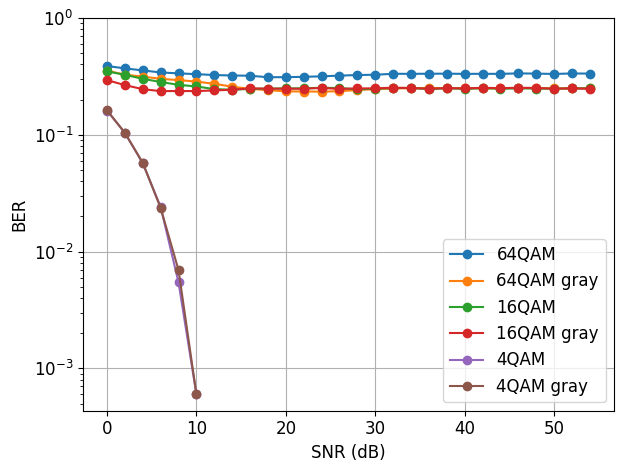

In [64]:
size = 10000
for m in [64, 16, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = qam_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}QAM")
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = qam_test(m, snr, size, gray=True)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}QAM gray")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("QAM_gray.png")
plt.savefig("QAM_gray.pdf")